In [ ]:
# hide
# all_tutorial
! [ -e /content ] && pip install -Uqq mrl-pypi  # upgrade mrl on colab

# Tutorial - Templates (Advanced)

>Advanced overview of using templates

## Block Overview

This tutorial follows from the <a href="/mrl/tutorials.template.beginner.html">Intermediate Template Tutorial</a>. This tutorial looks at using the `Block` class to apply different templates to different parts of the molecule.

For a full description of the `Block` class, see the <a href="/mrl/template.blocks.html">Blocks</a> page. Here we will do a brief overview.

The basic idea is that instead of generating a compound of the form `X-Y-Z`, we generate a string of fragments `*X.*Y*.*Z`. When we use a block template to analyze this compound, we first screen `*X`, `*Y*` and `*Z` separately with different templates. Then we fuse the fragments into a single compound `X-Y-Z` and screen the full compound against a template.

## Block Structure

A `Block` consists of a `Template` and a set of `links` that determine how a block connects to other blocks. Links are defined by adding isotope and map numbers to wildcard atoms, ie `* >> [{isotope}*:{map_num}]`. Map numbers determine how fragments link together, while isotopes differentiate wildcard atoms with the same map number. Isotope values should be `1` or `2`. Applying this to the above example, `*X.*Y*.*Z` would become `[1*:1]X.[2*:1]Y[2*:2].[1*:2]Z`. This tells us that `[1*:1]` should link to `[2*:1]` (same map number, different isotope), and the same for `[2*:2]` and `[1*:2]`

Blocks are arranged in a tree structure with the head block representing the full molecule. For this example, our block structure would look like

```
Block 1 - head block, full molecule template, links=[]
    Block 2 - X block, X template, links=['[1*:1]']
    Block 3 - Y block, Y template, links=['[2*:1]', '[2*:2]']
    Block 4 - Z block, Z template, links=['[1*:2]']
```

When we pass a string of fragments to the head block for screening, the string is first broken down into individual fragments. The links present on these fragments are compared to the links defined in each block. If the links in a fragment match the links in a block, the fragment is routed to that block for analysis.

Once all fragments have been routed, they are fused into a single compound and passed to the full molecule template. For a fragment string to pass the hard filters in the block tree, all fragments must match the link structure of the blocks and pass the templates present in the blocks.

## Block Recursion

Blocks are fully recursive, and can be nested as needed. Say our structure `X` was actually composed of substructures that we wanted to analyze individually, ie `X = A-B`. We can add another layer to the block tree. 

First we define how fragments break down. If `X = A-B`, then `*X = *A-B`. Then our fragments would have the form `*X = *A*.*B`. Previously we added links to `X` to get `[1*:1]X`. Now we specify links on `A` and `B` such that they resolve into `[1*:1]X`. `[1*:1]A[1*:3].[2*:3]B >> [1*:1]A-B >> [1*:1]X`. Note that we use atom map number `3` for `A` and `B`.

Then we change our generated sequence from `*X.*Y*.*Z` to `*A*.*B.*Y*.*Z`. 

Next we add map numbers. `[1*:1]A[1*:3].[2*:3]B.[2*:1]Y[2*:2].[1*:2]Z`.

Now we build our block structure

```
Block 1 - head block, full molecule template, links=[]
    Block 2 - X block, X template, links=['[1*:1]']
        Block 3 - A block, A template, links=['[1*:1]', '[1*:3]']
        Block 4 - B block, B template, links = ['[2*:3]']
    Block 5 - Y block, Y template, links=['[2*:1]', '[2*:2]']
    Block 6 - Z block, Z template, links=['[1*:2]']
```

Lets walk through what happens to a fragment string.

`[1*:1]A[1*:3].[2*:3]B.[2*:1]Y[2*:2].[1*:2]Z` is passed to `Block 1`.

The string is broken down into a list `['[1*:1]A[1*:3]', '[2*:3]B', '[2*:1]Y[2*:2]', '[1*:2]Z']`

Individual fragments are routed to blocks in the first tier (Blocks 2,5,6) based on their link configuration. 

* `[2*:1]Y[2*:2]` is routed to Block 5, Y block
* `[1*:2]Z` is routed to Block 6, Z block
* `[1*:1]A[1*:3]` and `[2*:3]B` are routed to Block 2, X block. These fragments don't match the links at X block, but they match links in subblocks

In Block 2, the same process happens recursively. 

* `[1*:1]A[1*:3]` is routed to Block 3, A block
* `[2*:3]B` is routed to Block 4, B block

After checking `A` against the `A` template and `B` against the `B` template, `A` and `B` are fused following the map numbers. `[1*:1]A[1*:3]+[2*:3]B >> [1*:1]A-B`. The fused fragment is then passed back up to Block 2, X block

`[1*:1]A-B` gets checked against the X template. Then `[1*:1]A-B` joins the `Y` and `Z` fragments.

`[1*:1]A-B`, `[2*:1]Y[2*:2]` and `[1*:2]Z` are then fused `[1*:1]A-B.[2*:1]Y[2*:2].[1*:2]Z >> B-A-Y-Z`.

The full compound `B-A-Y-Z` is then checked against the full molecule template in Block 1.

The output of all this contains a boolean denoting if the original fragment passed all templates and a score from the soft filters in each template.

In [ ]:
import sys
sys.path.append('..')

from mrl.imports import *
from mrl.core import *
from mrl.chem import *
from mrl.templates.all import *
from rdkit import Chem
from rdkit.Chem import rdMolDescriptors

/home/dmai/miniconda3/envs/mrl/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: to-Python converter for boost::shared_ptr<RDKit::FilterCatalogEntry const> already registered; second conversion method ignored.
  return f(*args, **kwds)


## Block Templates

Lets look at the case of optimizing two R groups on a pre-determined scaffod. Here's the scaffold with defined R-group substitution sites

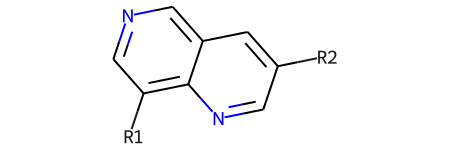

In [ ]:
mol = to_mol('c1nc2c(*)cncc2cc1[*] |$;;;;R1;;;;;;;R2$|')
mol

We want to impose different requirements on `R1` and `R2`.

R1 Requirements:
* Molecular weight between 50 and 250 (hard)
* Exactly 1 ring (hard)
* Molecular weight between 100 and 200 (soft)

R2 Requirements:
* Molecular weight between 0 and 150 (hard)
* Exactly 0 rings (hard)
* Molecular weight between 50 and 100 (soft)

We also have requirements for the full compound:
* Must be a valid chemical structure (hard)
* Must be a single compound (hard)
* Molecular weight between 200 and 500 (hard)

Note how these requirements interact. Our scaffold weighs 128 g/mol. We set limits on `R1` and `R2` of 250 and 150 g/mol respectively. This gives a maximum weight of 528 g/mol. The full molecule weight limit of 500 cuts off the heavy end of this range, so it is possible for a set of fragments to pass the fragment-level templates but fail the full molecule template.

The soft filters on weight for 100-200 on R1 and 50-100 on R2 set our desired weight range to be between 278 and 428 g/mol.

The single compound requirement on the full compound will reject any incorrect sequences that don't resolve to a full compound. This eliminates cases where a generative model incorrectly creates a fragment sequence (more on adapting generative models to the Block format later).

Now we create templates from these specifications.

In [ ]:
r1_template = Template(
                    [MolWtFilter(50, 250),
                     RingFilter(1,1)],
                    [MolWtFilter(100, 200, 1)],
                    fail_score=-1, log=True
                    )

r2_template = Template(
                    [MolWtFilter(0, 200),
                     RingFilter(None,0)],
                    [MolWtFilter(50,150,1)],
                    fail_score=-1, log=True
                    )

full_template = Template(
                    [MolWtFilter(200, 550)],
                    fail_score=-1, log=True)

Next we need to create our mapping setup.

Our chemotype has the format

`c1nc2c(R1)cncc2cc1[R2]`

We convert the R groups to wildcards

`c1nc2c(*)cncc2cc1[*]`

We add in R groups to the fragment string

`*R1.*R2.c1nc2c(*)cncc2cc1[*]`

Now we add isotope map numbers to the wildcards.

`[2*:1]R1.[2*:2]R2.c1nc2c([1*:1])cncc2cc1[1*:2]`

Note how the map numbers (the number after the `:`) match up between the scaffold and the r-groups to bring us back to the initial state of 

`c1nc2c(R1)cncc2cc1[R2]`

Next we start building blocks. First we'll create a block for the scaffold. Since the scaffold is constant, we will use the `ConstantMolBlock` which is a block specific for constant SMILES strings

In [ ]:
scaffold_smile = 'c1nc2c([1*:1])cncc2cc1[1*:2]'
scaffold_block = ConstantMolBlock(scaffold_smile, name='scaffold')
scaffold_block

Constant Block: c1nc2c([1*:1])cncc2cc1[1*:2]

Next we make blocks for the R groups using the `MolBlock` class. To create a block, we pass a Template and a set of links. Links for SMILES strings follow the convention `{isotope}*:{map_number}`, leaving out the brackets used in SMILES syntax.

For the R1 block, `links=['2*:1']`

For the R2 block, `links=['2*:2']`

In [ ]:
r1_block = MolBlock(r1_template, links=['2*:1'], name='r1')
r1_block

Block r1: ['2*:1']
	Template
		Hard Filter:
			molwt (50, 250)
			rings (1, 1)
		Soft Filter:
			molwt (100, 200)

In [ ]:
r2_block = MolBlock(r2_template, links=['2*:2'], name='r2')
r2_block

Block r2: ['2*:2']
	Template
		Hard Filter:
			molwt (0, 200)
			rings (None, 0)
		Soft Filter:
			molwt (50, 150)

Now we create the head block for the full molecule. We pass in the blocks for the scaffold, R1 and R2 as subblocks

In [ ]:
head_block = MolBlock(full_template, links=[], name='full_molecule',
                     subblocks=[scaffold_block, r1_block, r2_block])
head_block

Block full_molecule: []
	Template
		Hard Filter:
			molwt (200, 550)
		Soft Filter:
			

	Constant Block: c1nc2c([1*:1])cncc2cc1[1*:2]
	Block r1: ['2*:1']
		Template
			Hard Filter:
				molwt (50, 250)
				rings (1, 1)
			Soft Filter:
				molwt (100, 200)
	Block r2: ['2*:2']
		Template
			Hard Filter:
				molwt (0, 200)
				rings (None, 0)
			Soft Filter:
				molwt (50, 150)

Now We pass the head block to a `BlockTemplate`. The `BlockTemplate` class gives a collection of Blocks the same `__call__` API as the `Tempate` class, which allows them to be interchanged. `BlockTemplate` also handles data logging as well as saving and loading templates

In [ ]:
block_template = BlockTemplate(head_block)
block_template

Block Template
	Block full_molecule: []
		Template
			Hard Filter:
				molwt (200, 550)
			Soft Filter:
				
	
		Constant Block: c1nc2c([1*:1])cncc2cc1[1*:2]
		Block r1: ['2*:1']
			Template
				Hard Filter:
					molwt (50, 250)
					rings (1, 1)
				Soft Filter:
					molwt (100, 200)
		Block r2: ['2*:2']
			Template
				Hard Filter:
					molwt (0, 200)
					rings (None, 0)
				Soft Filter:
					molwt (50, 150)

At this point, we can save our template

In [ ]:
block_template.save('r1r2.template')
os.remove('r1r2.template') # clean up so I don't commit to github

Now we can use this block template. We load a list of 2000 SMILES strings. We'll use the `fragment_smiles` function to fragment these smiles

In [ ]:
df = pd.read_csv('files/smiles.csv')
fragments = fragment_smiles(df.smiles.values, [1,2])
len(df.smiles.values), len(fragments)

(2000, 38451)

In [ ]:
fragments[:5]

['*c1ccc(*)c(NC(=O)c2ccccc2OC(C)=O)c1',
 '*CNC(=O)c1cc([N+](=O)[O-])ccc1N1CCOCC1',
 '*[NH2+]C1(c2cccc(Br)c2)CCOCC1',
 '*Cc1nn(C)c(N(C)CCCc2ccccc2)c1*',
 '*c1ccccc1NC(=O)CSc1nc2ccc(Br)cc2[nH]1']

Now we can pass these SMIES and fragments through the template using the `BlockTemplate.load_data` function.

This function passes the inputs through the block tree. At each block node, the inputs are screened. If an input matches the link structure and template at a given node, the input is added to the template log at that node.



In [ ]:
block_template.load_data(fragments, recurse=True)

We can check the soft logs of our leaf nodes (in this case R1 and R2) and see that they have been populated with fragments that match the template and link structure of each block. Note that the `load_data` function handled mapping fragments with the correct `[{isotope}*:{map_num}]` configuration

In [ ]:
block_template.node_dict['r1'].template.soft_log

,smiles,0,final
0,O=C(OC[2*:1])c1cccc(NC(=O)C(F)(F)F)c1,0.0,0.0
1,Cc1c[nH]c([2*:1])[nH+]1,0.0,0.0
2,Cc1nc(CC=CC[2*:1])cs1,1.0,1.0
3,C1CC(O[2*:1])C1,0.0,0.0
4,Cc1nccn1CC[NH+](C)CC[2*:1],1.0,1.0
...,...,...,...
4615,C[NH+](CCOc1cccc(F)c1)[2*:1],1.0,1.0
4616,C[NH+](C)CCN(Cc1ccc(F)cc1)C(=O)[2*:1],0.0,0.0
4617,O=C(C[2*:1])NCC(=O)c1ccccc1,1.0,1.0
4618,C[NH+](C)C1(CNC(=O)[2*:1])CCOCC1,1.0,1.0


In [ ]:
block_template.node_dict['r2'].template.soft_log

,smiles,0,final
0,FC(F)(F)CO[2*:2],1.0,1.0
1,CCN(CCC#N)[2*:2],1.0,1.0
2,CC(C)OCC(=O)[2*:2],1.0,1.0
3,CCOCC[2*:2],1.0,1.0
4,CCCCN(C)[2*:2],1.0,1.0
...,...,...,...
552,CC(C)OC[2*:2],1.0,1.0
553,CC#CC[2*:2],1.0,1.0
554,CC=CCC[2*:2],1.0,1.0
555,N#CCO[2*:2],1.0,1.0


We can now sample from these datasets. The `BlockTemplate.sample_leaf_nodes` function draws a random fragment from the data log of each leaf node. Passing `include_constant=True` adds constant block sequences (in this case the scaffold).

In [ ]:
block_template.sample_leaf_nodes(1, include_constant=False) # no scaffold

['CS(=O)(=O)N1CCN(CC[2*:1])CC1.CC(C)(O)CS[2*:2]']

In [ ]:
block_template.sample_leaf_nodes(1, include_constant=True) # scaffold

['c1nc2c([1*:1])cncc2cc1[1*:2].Nc1cc[nH+]c([2*:1])c1.CC(=O)C(C)(C)[2*:2]']

We now generate 100 fragment strings without the constant

In [ ]:
frag_strings = block_template.sample_leaf_nodes(100, include_constant=False)

In [ ]:
frag_strings[:3]

['N#Cc1ccc(NCCCC(=O)N[2*:1])c(Cl)c1.CC(C)(C)C(=O)NCCCNC(=O)[2*:2]',
 'CCc1c(N)nnn1CC[2*:1].C=CCC(=O)N[2*:2]',
 'CN(CC[2*:1])c1ccccc1F.CC[NH2+][2*:2]']

We now process these fragment strings with the `BlockTemplate.recurse_fragments` function, passing `add_constant=True` to indicate the constant regions are not currently included in the fragments

In [ ]:
outputs = block_template.recurse_fragments(frag_strings, add_constant=True)

The output gives us the fragment string, fused molecule, hardpass and soft score for each fragment input

In [ ]:
outputs[0]

['N#Cc1ccc(NCCCC(=O)N[2*:1])c(Cl)c1.CC(C)(C)C(=O)NCCCNC(=O)[2*:2]',
 'CC(C)(C)C(=O)NCCCNC(=O)c1cnc2c(NC(=O)CCCNc3ccc(C#N)cc3Cl)cncc2c1',
 True,
 0.0]

These resuts are stored internally in two datafames. The `log` attribute contains basic pass/score information

In [ ]:
log_df = pd.DataFrame(block_template.log, columns=['fragments', 'fused', 'hardpass', 'score'])
log_df.head()

,fragments,fused,hardpass,score
0,N#Cc1ccc(NCCCC(=O)N[2*:1])c(Cl)c1.CC(C)(C)C(=O...,CC(C)(C)C(=O)NCCCNC(=O)c1cnc2c(NC(=O)CCCNc3ccc...,True,0.0
1,CCc1c(N)nnn1CC[2*:1].C=CCC(=O)N[2*:2],C=CCC(=O)Nc1cnc2c(CCn3nnc(N)c3CC)cncc2c1,True,2.0
2,CN(CC[2*:1])c1ccccc1F.CC[NH2+][2*:2],CC[NH2+]c1cnc2c(CCN(C)c3ccccc3F)cncc2c1,True,1.0
3,Cc1ccc([2*:1])cc1[N+](=O)[O-].CCC(CC)C(=O)N[2*:2],CCC(CC)C(=O)Nc1cnc2c(-c3ccc(C)c([N+](=O)[O-])c...,True,2.0
4,Cc1ccccc1C(=O)NN=C[2*:1].CCC(C=O)=C[2*:2],CCC(C=O)=Cc1cnc2c(C=NNC(=O)c3ccccc3C)cncc2c1,True,2.0


We can see that most of the fragments we generated through sampling have `hardpass==True`, meaning they pass all filters at every node

In [ ]:
log_df.hardpass.mean()

1.0

For more detailed information, the `block_log` attribute contains block level log information

In [ ]:
pd.DataFrame(block_template.block_log).head()

,block,fused,fragments,block_pass,block_score,all_pass,all_score,input_id
0,r1,N#Cc1ccc(NCCCC(=O)N[2*:1])c(Cl)c1,[N#Cc1ccc(NCCCC(=O)N[2*:1])c(Cl)c1],True,0.0,True,0.0,0
1,r2,CC(C)(C)C(=O)NCCCNC(=O)[2*:2],[CC(C)(C)C(=O)NCCCNC(=O)[2*:2]],True,0.0,True,0.0,0
2,full_molecule,CC(C)(C)C(=O)NCCCNC(=O)c1cnc2c(NC(=O)CCCNc3ccc...,"[c1nc2c([1*:1])cncc2cc1[1*:2], N#Cc1ccc(NCCCC(...",True,0.0,True,0.0,0
3,r1,CCc1c(N)nnn1CC[2*:1],[CCc1c(N)nnn1CC[2*:1]],True,1.0,True,1.0,1
4,r2,C=CCC(=O)N[2*:2],[C=CCC(=O)N[2*:2]],True,1.0,True,1.0,1


## Building Datasets

The process we just ran is a great way to generate targeted chemical datasets. The general procedure is as follows:

1. Get some SMILES dataset
2. Fragment dataset
3. Pass fragments through `load_data` recursively
4. Sample fragment strings from leaf nodes
5. Screen fragments with `recurse_fragments`

This provides a way to build targeted chemical datasets using blocks and templates to control chemical space

## Adapting Generative Models

If we want to use block templates in a generative modeling/reinforcement leaning context, we need our generative models to create sequences compatible with the template. For the `R1-Scaffold-R2` example we have been working on, we need sequences generated by the model to have the form `[2*:1]R1.[2*:2]R2`. How do we do this?

First we need a dataset of compounds matching this pattern. We've already discussed how to build datasets using block templates, so all good there.

Now we need to change the tokenization structure of the generative model to account for this. We could continue with the standard approach of tokenizing by character. However this can lead to some model confusion. If we tokenize by character, `CC[2*:1]` becomes `['C', 'C', '[', '2', '*', ':', '1', ']']`. The tokens `1` and `2` already exist in the SMILES alphabet to denote ring openings and closures. If we tokenize our links by character, we overload the meaning of `1` and `2`. We also open up the possibility for the model to produce invalid links.

A cleaner approach is to treat the links `[2*:1]` as tokens. `CC[2*:1]` would become `['C', 'C', '[2*:1]']`. This treats links as a single token unit, which makes a lot more sense.

See the toknization section in the `Vocab` module for details

## Nested Block Templates

In the above example, we had a block tree of the form:

```
Block 1 - Full Molecule, links=[]
    Block 2 - Scaffold (Constant), links=['1*:1', '1*:2']
    Block 3 - R1, links=['2*:1']
    Block 4 - R2, links=['2*:2']
```

Lets make this a bit more complex to show how the Block structure can be used to further break down molecules.

We specified before that `R1` should have exactly 1 ring. Lets break this down further. Lets say that `R1` should have 1 ring we'll call `R1_ring` with 1 carbonyl group and one other substitution that we'll call `R1_1`.

Lets say that `R1_1` should have 3 or fewer rotatable bonds and contain zero rings. We can express this with the Block template system.

First we need to break down `R1` into constituent parts. 

`R1 >> carbonyl-R1_ring-R1_1 >> carbonyl.R1_ring.R1_1`

Now we need to add links, starting with `R1_ring`. The ring needs 3 links - one for the carbonyl, one for `R1_1` and one to connect to the main molecule. We used map number `1` to link `R1` to the scaffold and `2` to link `R2` to the scaffold. We'll use `3` to link `R1_1` to `R1_ring` and `4` to link the carbonyl to `R1_ring`.

This gives us the following block structure relative to the R1 block

```
Block 3 - R1, links=['2*:1']
    Block 5 - Carbonyl (constant), links=['1*:4']
    Block 6 - R1_ring, links=['2*:1', '2*:3', '2*:4']
    Block 7 - R1_1, links=['1*:3']
```

For the following full block structure

```
Block 1 - Full Molecule, links=[]
    Block 2 - Scaffold (Constant), links=['1*:1', '1*:2']
    Block 3 - R1, links=['2*:1']
        Block 5 - Carbonyl (constant), links=['1*:4']
        Block 6 - R1_ring, links=['2*:1', '2*:3', '2*:4']
        Block 7 - R1_1, links=['1*:3']
    Block 4 - R2, links=['2*:2']
```

Now we can proceed. We start by making templates

In [ ]:
r1_template = Template(
                    [MolWtFilter(50, 250),
                     RingFilter(1,1)],
                    [MolWtFilter(100, 200, 1)],
                    fail_score=-1, log=True
                    )

r1_ring_template = Template(
                    [RingFilter(1,1)], log=True
                    )

r1_substitution_template = Template(
                            [RotBondFilter(0,3),
                             RingFilter(None,0)], log=True
                            )

r2_template = Template(
                    [MolWtFilter(0, 200),
                     RingFilter(None,0)],
                    [MolWtFilter(50,150,1)],
                    fail_score=-1, log=True
                    )


full_template = Template(
                    [MolWtFilter(200, 550)],
                    fail_score=-1, log=True)

And now we make the blocks

In [ ]:
scaffold_smile = 'c1nc2c([1*:1])cncc2cc1[1*:2]'
scaffold_block = ConstantMolBlock(scaffold_smile, name='scaffold')

carbonyl_smile = 'C(O)(=O)[1*:4]'
carbonyl_block = ConstantMolBlock(carbonyl_smile, 'carbonyl')

r1_ring_block = MolBlock(r1_ring_template, links=['2*:1', '2*:3', '2*:4'], name='r1_ring')

r1_substitution_block = MolBlock(r1_substitution_template, links=['1*:3'], name='r1_substitution')

# note how we add subblocks to R1 block
r1_block = MolBlock(r1_template, links=['2*:1'], name='r1', 
                    subblocks=[carbonyl_block, r1_ring_block, r1_substitution_block])

r2_block = MolBlock(r2_template, links=['2*:2'], name='r2')


head_block = MolBlock(full_template, links=[], name='full_molecule',
                     subblocks=[scaffold_block, r1_block, r2_block])


block_template = BlockTemplate(head_block)

In [ ]:
block_template

Block Template
	Block full_molecule: []
		Template
			Hard Filter:
				molwt (200, 550)
			Soft Filter:
				
	
		Constant Block: c1nc2c([1*:1])cncc2cc1[1*:2]
		Block r1: ['2*:1']
			Template
				Hard Filter:
					molwt (50, 250)
					rings (1, 1)
				Soft Filter:
					molwt (100, 200)
		
			Constant Block: O=C(O)[1*:4]
			Block r1_ring: ['2*:1', '2*:3', '2*:4']
				Template
					Hard Filter:
						rings (1, 1)
					Soft Filter:
						
			Block r1_substitution: ['1*:3']
				Template
					Hard Filter:
						rotbond (0, 3)
						rings (None, 0)
					Soft Filter:
						
		Block r2: ['2*:2']
			Template
				Hard Filter:
					molwt (0, 200)
					rings (None, 0)
				Soft Filter:
					molwt (50, 150)

Now we can follow the same procedure as before

In [ ]:
fragments = fragment_smiles(df.smiles.values, [1,2,3,4])

In [ ]:
len(fragments)

57554

In [ ]:
fragments[:5]

['*Oc1cc(*)c(*)cc1NCC(=O)Nc1cc(OC)c([N+](=O)[O-])cc1C',
 '*c1ccc(*)c(NC(=O)c2ccccc2OC(C)=O)c1',
 '*COc1ccccc1CCNC(=O)N(*)*',
 '*NC(=O)c1sc2nc(C)nc(N(*)*)c2c1*',
 '*Oc1cccc(C(=O)NC(*)(C)c2nc(*)cs2)c1F']

In [ ]:
block_template.load_data(fragments, recurse=True)

In [ ]:
frag_strings = block_template.sample_leaf_nodes(1000, include_constant=False)

In [ ]:
frag_strings[:5]

['O=C(NCc1cccc(N([2*:3])[2*:4])[nH+]1)N[2*:1].CC(C)(C)C(=O)NCC[1*:3].CCC(CC)(NC(=O)C[2*:2])C(N)=NO',
 'FC(F)(F)c1cc([2*:1])c([2*:3])c([2*:4])c1.CCC(C=O)=C[1*:3].COC(=O)[2*:2]',
 'O=S(=O)(c1cc(Br)ccc1[2*:1])N(C[2*:3])C[2*:4].CC(C)(C)NC(=O)C[1*:3].CN(CCS(C)(=O)=O)C[2*:2]',
 'CC1([2*:3])C([NH2+]CC(=O)OC[2*:1])C1(C)[2*:4].CCCO[1*:3].COCC[2*:2]',
 'O=C(Nc1ccc(NC(=O)[2*:4])c([2*:3])c1)N[2*:1].CC(N)=C(C#N)C(=O)C[1*:3].CC(C)(C)[NH2+][2*:2]']

In [ ]:
outputs = block_template.recurse_fragments(frag_strings, add_constant=True)

In [ ]:
outputs[0]

['O=C(NCc1cccc(N([2*:3])[2*:4])[nH+]1)N[2*:1].CC(C)(C)C(=O)NCC[1*:3].CCC(CC)(NC(=O)C[2*:2])C(N)=NO',
 'CCC(CC)(NC(=O)Cc1cnc2c(NC(=O)NCc3cccc(N(CCNC(=O)C(C)(C)C)C(=O)O)[nH+]3)cncc2c1)C(N)=NO',
 False,
 -2.0]

In [ ]:
log_df = pd.DataFrame(block_template.log, columns=['fagments', 'fused', 'hardpass', 'score'])

In [ ]:
log_df[log_df.hardpass==True]

,fagments,fused,hardpass,score
5,c1cc([2*:1])ccc1CC([2*:3])[2*:4].COCC[NH2+][1*...,CCC(CC)(CCO)CNc1cnc2c(-c3ccc(CC([NH2+]CCOC)C(=...,True,1.0
16,c1c[nH+]c(N([2*:3])[2*:4])c(C[2*:1])c1.CC[NH2+...,CC[NH2+]N(C(=O)O)c1[nH+]cccc1Cc1cncc2cc(CC(=O)...,True,2.0
30,C(=C([2*:1])[2*:4])c1cccn1[2*:3].C[NH+]=C(N)S[...,C[NH+]=C(N)Sn1cccc1C=C(C(=O)O)c1cncc2cc(N(C)C(...,True,1.0
46,c1cc([2*:3])n(C([2*:1])[2*:4])n1.CCC(CC)[NH+](...,CCC[NH2+]CCc1cnc2c(C(C(=O)O)n3nccc3[NH+](C)C(C...,True,1.0
51,O=c1cc([2*:4])c([2*:3])nn1[2*:1].[NH3+]C[1*:3]...,[NH3+]Cc1nn(-c2cncc3cc([S-])cnc23)c(=O)cc1C(=O)O,True,1.0
...,...,...,...,...
966,n1c(O[2*:1])nc([2*:4])nc1[2*:3].CC(=O)[1*:3].C...,CC(=O)c1nc(Oc2cncc3cc(SCCC(C)C)cnc23)nc(C(=O)O)n1,True,2.0
971,Cc1nn(C(C)[2*:1])c([2*:3])c1[2*:4].C#CCNC(=O)C...,C#CCNC(=O)Cc1c(C(=O)O)c(C)nn1C(C)c1cncc2cc(C(=...,True,1.0
974,C(C[2*:4])c1nnc(N(C[2*:3])[2*:1])s1.ClC[1*:3]....,CSC(C)(C)CNC(=O)NCc1cnc2c(N(CCCl)c3nnc(CCC(=O)...,True,0.0
983,CN(c1ccc(C[NH+](C[2*:1])[2*:4])cc1)[2*:3].OCC#...,CCCC(=O)OCc1cnc2c(C[NH+](Cc3ccc(N(C)C#CCO)cc3)...,True,1.0


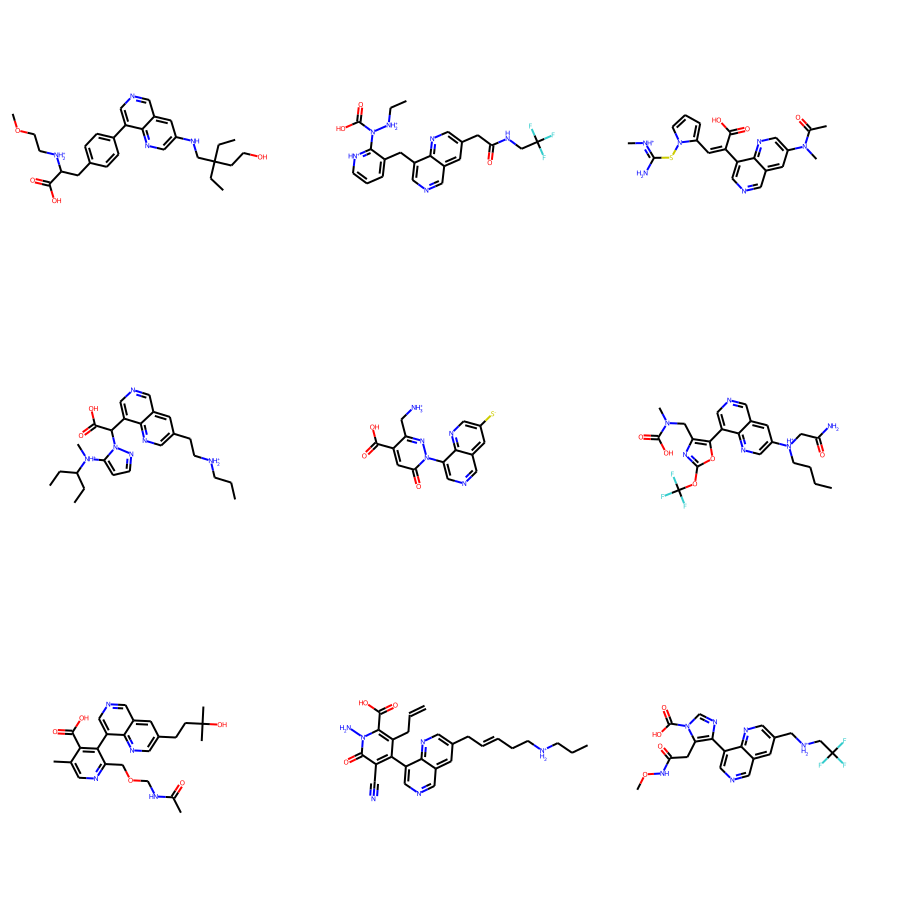

In [ ]:
Chem.Draw.MolsToGridImage(to_mols(log_df[log_df.hardpass==True].fused.values[:9]), subImgSize=(300,300))